# ConvLSTM

동영상은 연속적인 이미지가 나열되어 표현되는 데이터입니다.

이 동영상 데이터를 처리하기 위해서는 이미지에 대한 데이터를 처할 수 있어야하며, 추가적으로 연속적으로 Input되는 데이터를 처할 수 있어야합니다. 

CNN과 LSTM을 융합하여 동영상데이터를 학습하여 다음 프레임을 예측하는 알고리즘을 실습해보았다

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

우리가 사용할 데이터셋은 Moving MNIST라는 데이터셋입니다. 

아래 링크를 걸어두었으니 데이터셋을 한번 확인해주세요!

링크 : http://www.cs.toronto.edu/~nitish/unsupervised_video/

## Data Contruction

In [ ]:
# Download and load the dataset.
fpath = keras.utils.get_file(
    "moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy",
)

dataset_load = np.load(fpath)

이 데이터는 총 프레임의 길이가 20인 동영상이 10000개 포함되어있고, 한 프레임은 64*64의 크기를 가지고 있습니다.

In [ ]:
dataset_load.shape

(20, 10000, 64, 64)

In [ ]:
dataset_1 = np.swapaxes(dataset_load, 0, 1)

dataset_2 = dataset_1[:50, ...]

dataset = np.expand_dims(dataset_2, axis=-1)

In [ ]:
indexes = np.arange(dataset.shape[0]) 
np.random.shuffle(indexes) 

train_index = indexes[: int(0.9 * dataset.shape[0])]
test_index = indexes[int(0.9 * dataset.shape[0]) :] 
train_dataset = dataset[train_index]
test_dataset = dataset[test_index]

train_dataset = train_dataset / 255
test_dataset = test_dataset / 255

In [ ]:
def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y


x_train, y_train = create_shifted_frames(train_dataset)
x_test, y_test = create_shifted_frames(test_dataset)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Test Dataset Shapes: " + str(x_test.shape) + ", " + str(y_test.shape))

Training Dataset Shapes: (45, 19, 64, 64, 1), (45, 19, 64, 64, 1)
Test Dataset Shapes: (5, 19, 64, 64, 1), (5, 19, 64, 64, 1)


## Visualization

데이터가 어떻게 생겼나 한번 확인해볼까요?

Displaying frames for example 39.


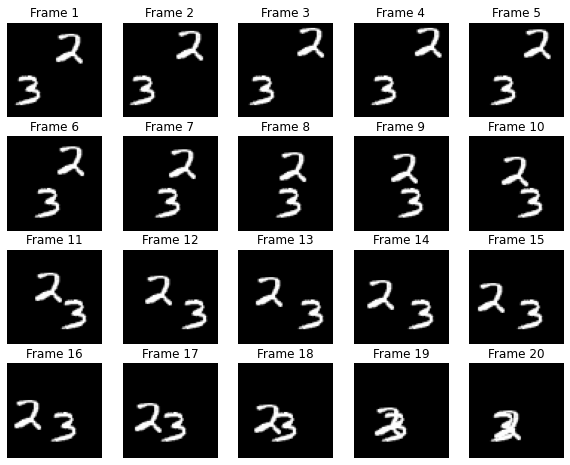

In [ ]:
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]

for idx, ax in enumerate(axes.flat):
    ax.imshow(train_dataset[data_choice][idx].reshape(64,64), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

print(f"Displaying frames for example {data_choice}.")
plt.show()

## Modeling

In [ ]:
inp = layers.Input(shape=(None, *x_train.shape[2:]))

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",
)(inp)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu",
)(x)
x = layers.Conv3D(
    filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same"
)(x)

model = keras.models.Model(inp, x)
model.compile(
    loss='binary_crossentropy', optimizer='adam',
)

In [ ]:
# Define modifiable training hyperparameters.
epochs = 20
batch_size = 5

# Fit the model to the training data.
model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_test, y_test),
)

In [ ]:
# Select a random example from the validation dataset.
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]

# Pick the first/last ten frames from the example.
frames = example[:10, ...]
original_frames = example[10:, ...]

# Predict a new set of 10 frames.
for _ in range(10):
    # Extract the model's prediction and post-process it.
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

    # Extend the set of prediction frames.
    frames = np.concatenate((frames, predicted_frame), axis=0)

# Construct a figure for the original and new frames.
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

# Plot the original frames.
for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Plot the new frames.
new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

# Display the figure.
plt.show()

In [ ]:
# Select a few random examples from the dataset.
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

# Iterate over the examples and predict the frames.
predicted_videos = []
for example in examples:
    # Pick the first/last ten frames from the example.
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    # Predict a new set of 10 frames.
    for i in range(10):
        # Extract the model's prediction and post-process it.
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)

        # Extend the set of prediction frames.
        new_predictions[i] = predicted_frame

    # Create and save GIFs for each of the ground truth/prediction images.
    for frame_set in [original_frames, new_predictions]:
        # Construct a GIF from the selected video frames.
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        # Construct a GIF from the frames.
        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

# Display the videos.
print(" Truth\tPrediction")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox(
        [
            widgets.Image(value=predicted_videos[i]),
            widgets.Image(value=predicted_videos[i + 1]),
        ]
    )
    display(box)